In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
# sns.set_theme()

import sys
sys.path.append(sys.path[0][:-23])

import imp

from ikd import utils, core, evaluate, datasets, epca
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)
imp.reload(epca)

<module 'ikd.epca' from 'd:\\GT\\Lab\\ikd NeurIPS 2022\\src\\ikd\\epca.py'>

In [11]:
df_list = []
for dataset in range(3):
    for kernel in ("squared exponential", "rational quadratic", "gamma-exponential", "matern"):
        for n_samples in (200, 500, 1000, 2000, 5000, 10000, 20000):
            df_list.append(pd.read_csv(f'outputs/{dataset}_{kernel}_{n_samples}.csv', index_col=0))
df = pd.concat(df_list, ignore_index=True)
df.n_samples = df.n_samples.astype(str)
df['method'] = df['method'].replace(['pca', 'full', 'block'], ['PCA', 'IKD', 'IKD-b'])
df['dataset'] = df['dataset'].replace([0, 1, 2], ['Hard', 'Medium', 'Easy'])
df['kernel'] = df['kernel'].replace(['gamma-exponential', 'matern'], ['$\\gamma$-exponential', 'Matérn'])

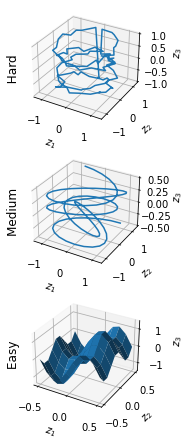

In [12]:
n_points = 100
d_latent = 3
fig, axs = plt.subplots(3, 1, figsize=(2, 6), subplot_kw=dict(projection='3d'), constrained_layout=True)
z_true = datasets.generate_latent(d_latent, 0, n_points=n_points)
axs[0].plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
axs[0].set_xlabel('$z_1$')
axs[0].set_ylabel('$z_2$')
axs[0].set_zlabel('$z_3$')

z_true = datasets.generate_latent(d_latent, 1, n_points=n_points)
axs[1].plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
axs[1].set_xlabel('$z_1$')
axs[1].set_ylabel('$z_2$')
axs[1].set_zlabel('$z_3$')

t = np.linspace(-0.5, 0.5, 10)
x, y = np.meshgrid(t, t)
z = np.sin(2 * np.pi * x) + np.cos(3 * np.pi * y) / 2
axs[2].plot_surface(x, y, z)
axs[2].set_xlabel('$z_1$')
axs[2].set_ylabel('$z_2$')
axs[2].set_zlabel('$z_3$')
# plt.tight_layout()
fig.supylabel('Easy                           Medium                           Hard')
fig.savefig('3 3D datasets.pdf', bbox_inches='tight')

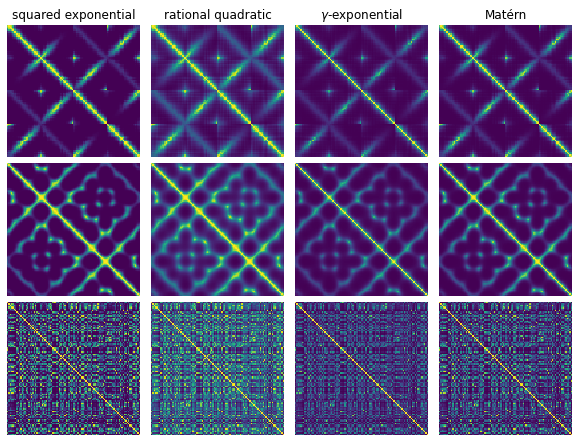

In [13]:
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"]
extra_kernel_hyperparam = [None, 1, 1, 3/2]
fig, axs = plt.subplots(3, 4, figsize=(8, 6), constrained_layout=True, sharex=True, sharey=True)
for dataset in range(3):
    z_true = datasets.generate_latent(d_latent, dataset, n_points=n_points, show=False)
    for kernel_idx in range(4):
        cov_true = utils.kernel_cov_generator(z_true, kernel=kernel[kernel_idx], variance=1, length_scale=0.5, extra_kernel_hyperparam=extra_kernel_hyperparam[kernel_idx])
        axs[dataset, kernel_idx].matshow(cov_true)
        axs[dataset, kernel_idx].axis('off')
axs[0, 0].set_title('squared exponential')
axs[0, 1].set_title('rational quadratic')
axs[0, 2].set_title('$\\gamma$-exponential')
axs[0, 3].set_title('Matérn')
plt.savefig('true covariance matrix.pdf')

In [14]:
d_latent = 3
dataset = 1
n_points = 100
d_observation = 200
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"][0]
extra_kernel_hyperparam = [None, 1, 1, 3/2][0]
variance = 1
length_scale = 0.5

z_true = datasets.generate_latent(d_latent, dataset, n_points=n_points, show=False)
cov_true = utils.kernel_cov_generator(z_true, kernel=kernel, variance=variance, length_scale=length_scale, extra_kernel_hyperparam=extra_kernel_hyperparam)
x = datasets.gaussian_process_generator(cov_true, d_observation, seed=0)
cov_samp_th = utils.filt_cov_samp(np.cov(x), variance=variance)

z_pca = PCA(n_components=d_latent).fit_transform(x)
z_ikd = core.ikd(cov_samp_th, d_latent, kernel=kernel, variance=variance, extra_kernel_hyperparam=extra_kernel_hyperparam)[0]
z_ikd_b = core.ikd_blockwise(cov_samp_th, d_latent, kernel=kernel, variance=variance, extra_kernel_hyperparam=extra_kernel_hyperparam, clique_th_or_d_observation=d_observation)

z_pca_aligned = utils.align(z_true, z_pca)
z_ikd_aligned = utils.align(z_true, z_ikd)
z_ikd_b_aligned = utils.align(z_true, z_ikd_b)

Clique threshold: 0.2397940008672037, number of cliques: 172


In [15]:
dataset_list = df.dataset.unique()
kernel_list = df.kernel.unique()

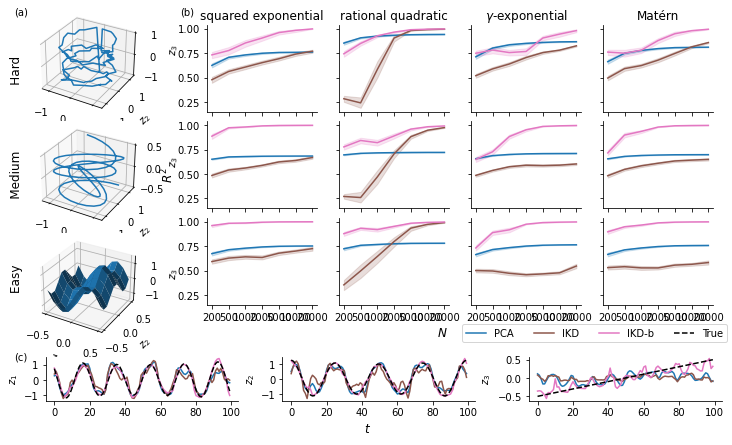

In [16]:
d_latent = 3
n_points = 100
kernel = ["squared exponential", "rational quadratic", "gamma-exponential", "matern"]
extra_kernel_hyperparam = [None, 1, 1, 3/2]
variance = 1
length_scale = 0.5

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
subfigs = fig.subfigures(2, 1, height_ratios=[5, 1], hspace=0.05)
subsubfigs = subfigs[0].subfigures(1, 2, width_ratios=[1, 4])
axs = subsubfigs[0].subplots(3, 1, subplot_kw=dict(projection='3d'))
z_true = datasets.generate_latent(d_latent, 0, n_points=n_points)
axs[0].plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
axs[0].set_xlabel('$z_1$')
axs[0].set_ylabel('$z_2$')
axs[0].set_zlabel('$z_3$')

z_true = datasets.generate_latent(d_latent, 1, n_points=n_points)
axs[1].plot(z_true[:, 0], z_true[:, 1], z_true[:, 2])
axs[1].set_xlabel('$z_1$')
axs[1].set_ylabel('$z_2$')
axs[1].set_zlabel('$z_3$')

t = np.linspace(-0.5, 0.5, 10)
x, y = np.meshgrid(t, t)
z = np.sin(2 * np.pi * x) + np.cos(3 * np.pi * y) / 2
axs[2].plot_surface(x, y, z)
axs[2].set_xlabel('$z_1$')
axs[2].set_ylabel('$z_2$')
axs[2].set_zlabel('$z_3$')
subsubfigs[0].supylabel('Easy                 Medium                 Hard')

axs = subsubfigs[1].subplots(3, 4, sharex=True, sharey=True)
for i in range(3):
    for j in range(4):
        ax = sns.lineplot(x='n_samples', y='r2_true', hue='method', data=df[np.bitwise_and((df.dataset == dataset_list[i]).values, (df.kernel == kernel_list[j]).values)], palette=['C0', 'C5', 'C6'], ax=axs[i, j], legend=False)
        ax.set(xlabel=None, ylabel=None)
        if i == 0:
            ax.set_title(kernel_list[j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
subsubfigs[1].supxlabel('$N$')
subsubfigs[1].supylabel('$R^2$')

axs = subfigs[1].subplots(1, 3, sharex=True)
for i in range(3):
    axs[i].plot(z_pca_aligned[:, i], label='PCA', c='C0')
    axs[i].plot(z_ikd_aligned[:, i], label='IKD', c='C5')
    axs[i].plot(z_ikd_b_aligned[:, i], label='IKD-b', c='C6')
    axs[i].plot(z_true[:, i], 'k--', label='True')
    axs[i].set_ylabel(f'$z_{i+1}$')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
fig.supxlabel('$t$')
handles, labels = axs[0].get_legend_handles_labels()
fig.text(0.01, 0.98, '(a)')
fig.text(0.24, 0.98, '(b)')
fig.text(0.01, 0.18, '(c)')
fig.legend(handles, labels, loc=(0.63, 0.23), ncol=4, fontsize=10, labelspacing=0)

# plt.tight_layout()
plt.savefig('exp2_noiseless_GP.pdf', bbox_inches='tight', transparent=True)